In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import sys
sys.path.insert(0, '../config/')
#frontExpo = [100,250,500,1000,2000,5000,10000]
#frontExpo = [10,20,50,100,200,500,4000,5000,8000,10000,20000]
frontExpo = [10,20,50,100,200,500,4000,5000,8000]
#backExpo = [500,1000,2000,5000]
#backExpo = [10,20,50,100,200,500,4000,5000,8000,10000]
backExpo = [10,20,50,100,200,500,4000,5000,8000]
#sidesExpo = [10,50,100,200,500,1000,2000,5000]
sidesExpo = [10,50,100,200,500,1000,2000]
qrExpo = [200]
pixel2discardTop = 200
pixel2dicardBottom = 200

pixelAreaGrid = 100
periCountMueFindBig = 300

calibrationFactor = 0.11
gridSize = 160



M = gridSize
N = M
# tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
basepath4tempImgs = '/home/nvidia/Documents/Workspace/Projects/RecvV2/'
class CreateGrid():
    def __init__(self):
        self.calibrationFactor = calibrationFactor
        pass

    def CreateTiles(self,gridX,gridY,img,imgRgb,side,imgName):
        M = gridX
        N = gridY
        img = np.uint8((img>250)*255)
        imgCrackDetected,imgRgbProcess = self.FindBiggerCnt(img.copy(),imgRgb,side)
        # cv2.imwrite(basepath4tempImgs + 'crackTiles/' + imgName, img)
        self.imgCrackDetected = imgCrackDetected.copy()
        img = np.uint8((imgCrackDetected>240)*255)
        tiles = [img[x:x + M, y:y + N] for x in range(0, img.shape[0], M) for y in range(0, img.shape[1], N)]
        self.tiles = tiles
        gridWiseCrackCount = []
        gridWiseImgs = []
        gridWiseL = []
        gridWiseW = []
        gridWiseLWCentroid = []
        for i in range(len(tiles)):
            imgCnt,crackCount,maxL,maxW,arrayLW = self.FindContours(tiles[i])
            gridWiseCrackCount.append(crackCount)
            gridWiseImgs.append(imgCnt)
            gridWiseL.append(maxL)
            gridWiseW.append(maxW)
            gridWiseLWCentroid.append(arrayLW)
        # print len(tiles)
        # print gridWiseCrackCount
        return gridWiseCrackCount,gridWiseImgs,imgCrackDetected,imgRgbProcess,gridWiseL,gridWiseW,gridWiseLWCentroid

    def WholeImgScratch(self,binImg,rgbImg):
        _, contour, cimage = cv2.findContours(binImg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        arrayLW = []
        for c in range(0, len(contour)):
            cnt = contour[c]
            area = cv2.contourArea(cnt)
            if area != 0:
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                # cv2.drawContours(rgbImg, [box], 0, (0, 75, 175), 2)
                length = max(rect[1])
                width = area / length
                lengthMM = self.calibrationFactor * length
                widthMM = self.calibrationFactor * width
                listWidLen = [lengthMM, widthMM]
                arrayLW.append(listWidLen)
                w,h = rect[1]
                if w > h:
                    aspectRatio = float(w)/float(h)
                else:
                    aspectRatio = float(h)/float(w)
                
                if (length < 15) or (aspectRatio > 1.85):
                    if (lengthMM > 0) and (lengthMM <= 5):
                        cv2.drawContours(rgbImg, [box], 0, (5, 175, 175), 1)
                    elif (lengthMM > 5) and (lengthMM <= 10):
                        cv2.drawContours(rgbImg, [box], 0, (5, 15, 255), 1)
                    elif (lengthMM > 10) and (lengthMM <= 15):
                        cv2.drawContours(rgbImg, [box], 0, (5, 255, 5), 1)
                    elif (lengthMM > 15) and (lengthMM <= 20):
                        cv2.drawContours(rgbImg, [box], 0, (175, 5, 5), 1)
                        
        if arrayLW == []:
            # No scratch detected
            return rgbImg,0,0,0,0
        else:
            arrayLW = np.array(arrayLW)
            length = arrayLW[:, 0]
            sum1to5mm = sum(((i > 0)and (i <= 5)) for i in length)
            sum5to10mm = sum(((i > 5)and (i<=10)) for i in length)
            sum10to15mm = sum(((i > 10)and (i<=15)) for i in length)
            sum15to20mm = sum(((i > 15)and (i<=20)) for i in length)
            return rgbImg,sum1to5mm,sum5to10mm,sum10to15mm,sum15to20mm
        # return rgbImg,arrayLW,1,1,1


    def FindBiggerCnt(self,binImg,rgbImg,side):
        if (side == 'front') or (side == 'back'):
            minArea = 5
            kernel = np.ones((7, 7), np.uint8)
        else:
            minArea = 5
            kernel = np.ones((3, 3), np.uint8)

        crackCount = 0
        img2DrawCnt = np.zeros((binImg.shape[0], binImg.shape[1]), np.uint8)
        # self.img2DrawCntRgb = cv2.cvtColor(img2DrawCnt.copy(), cv2.COLOR_GRAY2RGB)
        self.img2DrawCntRgb = rgbImg

        # dilation = cv2.dilate(np.uint8(binImg.copy()), kernel, iterations=1)
        # erode = cv2.erode(np.uint8(dilation.copy()), kernel, iterations=1)
        erode = binImg
        self.erode = erode

        _,contour, cimage = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # contour, cimage = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for c in range(0, len(contour)):
            cnt = contour[c]
            area = cv2.contourArea(cnt)
            if area > minArea:
                # cv2.drawContours(self.img2DrawCntRgb, [cnt], 0, (255, 0, 0), 1)
                cv2.drawContours(img2DrawCnt, [cnt], 0, 255, 1)
                # print area
                crackCount = crackCount + 1
                # print crackCount
        return img2DrawCnt,self.img2DrawCntRgb



    def FindContours(self,tile):
        crackCount = 0
        listLWCent = []
        img2DrawCnt = np.ones((tile.shape[0],tile.shape[1]),np.uint8)
        img2DrawCnt = cv2.cvtColor(img2DrawCnt.copy(),cv2.COLOR_GRAY2RGB)
        _,contour, cimage = cv2.findContours(tile.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        arrayLW = []
        minArea = 0
        for c in range (0,len(contour)):
            cnt = contour[c]
            area = cv2.contourArea(cnt)
            #if area > minArea:
                # print "area Find cnt",area
            #cv2.drawContours(img2DrawCnt,[cnt],0,(255,0,0),1)
            rect = cv2.minAreaRect(cnt)
            if area != 0:
                length = max(rect[1])
                    # print area, length
                width = area / length
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                centX = box[0][0]
                centY = box[0][1]
                listWidLen = [length, width,centX,centY]
                arrayLW.append(listWidLen)
                cv2.drawContours(img2DrawCnt, [box], 0, (0, 0, 255), 1)
                crackCount = crackCount+1
        maxL=0
        maxW=0
        # print type(arrayLW)
        if arrayLW != []:
            # print type(arrayLW)
            listLWCent = arrayLW
            arrayLW = np.array(arrayLW)
            maxL = max(arrayLW[:,0])
            maxW = max(arrayLW[:,1])
            maxLW = [maxL,maxW]
        # maxLW = np.array(maxLW)
            # print "arrayLW", maxLW
        return img2DrawCnt,crackCount,maxL,maxW,listLWCent


    def DrawGrid(self,img2DrawGrid):
        for i in range(0, img2DrawGrid.shape[1], M):
            cv2.line(img2DrawGrid, (i, 0), (i, img2DrawGrid.shape[0]), (125,125,125), 1)

        for i in range(0, img2DrawGrid.shape[0], N):
            cv2.line(img2DrawGrid, (0, i), (img2DrawGrid.shape[1], i), (125,125,125), 1)
        self.img2DrawGrid = img2DrawGrid
        return img2DrawGrid

    def WriteInfoOnImg(self,img,text2Write,bottomLeftCornerOfText,fontColor):
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        fontScale = 1
        # fontColor = (0, 255, 0)
        lineType = 2
        cv2.putText(img, str(text2Write),bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
        return img

    def Text2Write(self,img,cnt1to5,cnt5to10,cnt10to15,cnt15to20):
        baseXpos= int(img.shape[1]-400)
        baseYpos = int(img.shape[0]-170)
        img = self.WriteInfoOnImg(img,'scratch 1-5mm :',(baseXpos,baseYpos),(5, 255, 5))
        img = self.WriteInfoOnImg(img,str(cnt1to5),(baseXpos+250,baseYpos),(5, 175, 175))
        img = self.WriteInfoOnImg(img,'scratch 5-10mm :',(baseXpos,baseYpos+25),(5, 255, 5))
        img = self.WriteInfoOnImg(img,str(cnt5to10),(baseXpos+250,baseYpos+25),(5, 15, 255))
        img = self.WriteInfoOnImg(img,'scratch 10-15mm :',(baseXpos,baseYpos+50),(5, 255, 5))
        img = self.WriteInfoOnImg(img,str(cnt10to15),(baseXpos+250,baseYpos+50),(5, 255, 5))
        img = self.WriteInfoOnImg(img,'scratch 15-20mm :',(baseXpos,baseYpos+75),(5, 255, 5))
        img = self.WriteInfoOnImg(img,str(cnt15to20),(baseXpos+250,baseYpos+75),(175, 5, 5))
        return img



In [3]:
import tensorflow as tf
from keras import applications
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Dropout, merge, BatchNormalization
import numpy as np
import keras.backend as K
from keras.models import load_model
from keras.optimizers import *
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
from keras.layers import concatenate,Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
#K.set_image_dim_ordering('tf')
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Dropout, merge, MaxPool2D
import numpy as np
import keras.backend as K
from keras.models import load_model
from keras.optimizers import *
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
from keras.layers import concatenate,Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
#K.set_image_dim_ordering('tf')
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.backend.tensorflow_backend import set_session
K.set_image_data_format(data_format='channels_last')
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
#K.set_image_dim_ordering('tf')

'''train = np.load('/home/ubuntu/MobileExtraction/Train256x324-full.npy')
labels = np.load('/home/ubuntu/MobileExtraction/Labels256x324-full.npy')
print(np.max(train),np.min(train))
x = np.argwhere(labels>0)
print(x.shape)
crf_labels = labels.flatten()
for i in range(x.shape[0]):
    labels[x[i][0],x[i][1],x[i][2]] = 1
train = train.reshape(train.shape[0],256,324)
trainNew = np.empty((394,256,324,3),dtype='float32')
trainNew[:,:,:,0]=train
trainNew[:,:,:,1]=train
trainNew[:,:,:,2]=train
print(np.unique(labels))
import tensorflow as tf
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)
print(labels.shape)
print(trainNew.shape)
labels=labels.astype('uint8')'''
smooth = 1.

#labels = to_categorical(y=labels,n)
#import tensorflow as tf
smooth = 1.
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)-K.log(dice_coef(y_true, y_pred))


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return 1-jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

import h5py
from keras.models import Model
from keras.layers import Input, Activation, Concatenate
from keras.layers import Flatten, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from skimage import io
import cv2
import numpy as np

def pad_input(input_img,patch_size=[256,256]):
    h = input_img.shape[0]
    w = input_img.shape[1]
    hMod = h % patch_size[0]
    wMod = w % patch_size[1]
    hPad=0
    wPad=0
    if(hMod!=0 or wMod!=0):
        hPad = patch_size[0]-hMod
        wPad = patch_size[1]-wMod
    output = np.pad(input_img, ((0, hPad),(0,wPad),(0,0)), 'constant')
    return(output)

def prediction_patches(img,patch_size=[256,256]):
    img = np.asarray(img).astype('float32')
    #print(img.shape)
    assert(img.shape[0]%patch_size[0]==0 and img.shape[1]%patch_size[1]==0)
    h_patch = int(img.shape[0]/patch_size[0])
    w_patch = int(img.shape[1]/patch_size[1])
    patches = []
    x = 0
   
    no = 0
    for i in range(h_patch):
        y = 0 
        for j in range(w_patch):
            
            
            patch = img[x:(((i+1)*patch_size[0])),y:(((j+1)*patch_size[1])),:]
            #print(y)
            #print(patch.shape)
            #print(j)
            y = ((j+1)*patch_size[1])
            #print('yes')
            no+=1
            patches.append(patch)
        x = ((i+1)*patch_size[0])
    
    return patches

def reconstruct_patches(patches= np.ones((16,256,256,3)),img_shape=[1024,1024,3]):
    full_img = np.empty(img_shape).astype('float32')
    h = img_shape[0]
    w = img_shape[1]
    c = img_shape[2]
    h_patch = int(h / patches.shape[1])
    w_patch = int(w / patches.shape[2])
    no = 0 
    x = 0
    
    #assert(h_patch*w_patch == patches.shape[0])
    for i in range(h_patch):
        y = 0
        for j in range(w_patch):
            full_img[x:(((i+1)*patches.shape[1])),y:((j+1)*patches.shape[2]),:] = patches[no]
            #print('yes')
            y = ((j+1)*patches.shape[2])
            no += 1  
        x = ((i+1)*patches.shape[1])
    return full_img

def LargeDilatedKernels(input_shape):
    inputs = Input((input_shape))
    x = Conv2D(64,(3,3),activation='relu',dilation_rate=(1,1),padding='same',kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(64,(3,3),activation='relu',dilation_rate=(1,1),padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(64,(3,3),activation='relu',dilation_rate=(2,2),padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(64,(3,3),activation='relu',dilation_rate=(2,2),padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(64,(3,3),activation='relu',dilation_rate=(3,3),padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(64,(3,3),activation='relu',dilation_rate=(3,3),padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(256,(3,3),activation='relu',dilation_rate=(3,3),padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(256,(1,1),activation='relu',dilation_rate=(1,1),padding='same',kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(1,(1,1),activation='sigmoid',padding='same',kernel_initializer='glorot_uniform')(x)
    model = Model(inputs=[inputs],outputs=[x])
    return model

def dilatedKernels(input_shape):
    inputs = Input((input_shape))
    conv1 = Conv2D(64,(7,7),activation='relu',dilation_rate=(1,1),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(inputs)
    conv2 = Conv2D(64,(7,7),activation='relu',dilation_rate=(2,2),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv1)
    conv3 = Conv2D(64,(7,7),activation='relu',dilation_rate=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv2)
    conv4 = Conv2D(64,(7,7),activation='relu',dilation_rate=(4,4),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv3)
    concat1 = concatenate([conv1,conv2,conv3,conv4],axis=1 )
    drop1 = Dropout(0.5)(concat1)
    conv11 = Conv2D(64,(5,5),activation='relu',dilation_rate=(1,1),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(drop1)
    conv12 = Conv2D(64,(5,5),activation='relu',dilation_rate=(2,2),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv11)
    conv12 = Dropout(0.5)(conv12)
    conv13 = Conv2D(64,(5,5),activation='relu',dilation_rate=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv12)
    conv14 = Conv2D(64,(5,5),activation='relu',dilation_rate=(4,4),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv13)
    concat2 = concatenate([conv11,conv12,conv13,conv14],axis=1 )
    drop2 = Dropout(0.5)(concat2)
    conv21 = Conv2D(64,(3,3),activation='relu',padding='same',dilation_rate=(1,1),kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(drop2)
    conv22 = Conv2D(64,(3,3),activation='relu',padding='same',dilation_rate=(2,2),kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv21)
    conv22 = Dropout(0.5)(conv22)
    conv23 = Conv2D(64,(3,3),activation='relu',padding='same',dilation_rate=(3,3),kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv22)
    conv24 = Conv2D(64,(3,3),activation='relu',padding='same',dilation_rate=(4,4),kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv23)
    concat3 = concatenate([conv21,conv22,conv23,conv24],axis=1 )
    drop3 = Dropout(0.5)(concat3)
    conv31 = Conv2D(64,(1,1),activation='relu',dilation_rate=(1,1),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(drop3)
    conv32 = Conv2D(64,(1,1),activation='relu',dilation_rate=(2,2),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv31)
    conv32 = Dropout(0.5)(conv32)
    conv33 = Conv2D(64,(1,1),activation='relu',dilation_rate=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv32)
    conv34 = Conv2D(64,(1,1),activation='relu',dilation_rate=(4,4),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv33)
    concat4 = concatenate([conv31,conv32,conv33,conv34],axis=1 )
    drop4 = Dropout(0.5)(concat4)
    conv41 = Conv2D(64,(3,3),activation='relu',dilation_rate=(1,1),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(drop4)
    conv42 = Conv2D(64,(3,3),activation='relu',dilation_rate=(2,2),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv41)
    conv42 = Dropout(0.5)(conv42)
    conv43 = Conv2D(64,(3,3),activation='relu',dilation_rate=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv42)
    conv44 = Conv2D(64,(3,3),activation='relu',dilation_rate=(4,4),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-5))(conv43)
    concat5 = concatenate([conv44,conv34,conv24,conv14,conv4],axis=1 )
    drop5 = Dropout(0.5)(concat5)
    final1 = Conv2D(128,(3,3),dilation_rate=(3,3),activation='relu',padding='same',kernel_initializer='glorot_uniform',kernel_regularizer=l2(1e-5))(drop5)
    final1 = Conv2D(128,(1,1),dilation_rate=(1,1),activation='relu',padding='same',kernel_initializer='glorot_uniform',kernel_regularizer=l2(1e-5))(final1)
    final1 = Dropout(0.5)(final1)
    finallast = Conv2D(1,(1,1),dilation_rate=(1,1),activation='sigmoid',padding='same',kernel_initializer='glorot_uniform',kernel_regularizer=l2(1e-5))(final1)
    model = Model(inputs=[inputs],outputs=[finallast])
    return model
def encoder_decoder(input_shape):
    return Sequential([
    
        Conv2D(32, (3, 3),dilation_rate=(3,3), activation='relu', padding='same',input_shape=input_shape),
        
        MaxPooling2D((2,2), strides=(2,2)),
        Dropout(0.3),
        Conv2D(64, (3, 3),dilation_rate=(2,2), activation='relu' ,padding='same',kernel_initializer='he_normal'),
      
        MaxPooling2D((2,2), strides=(2,2)),
        Dropout(0.3),
        Conv2D(128, (3, 3),dilation_rate=(1,1), activation='relu',padding='same',kernel_initializer='he_normal'),
        MaxPooling2D((2,2), strides=(2,2)),
        Dropout(0.3),
        Conv2D(256, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'),
        MaxPooling2D((2,2), strides=(2,2)),
        Dropout(0.3),
        Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal'),
      
        UpSampling2D(size=(2,2)),
        Dropout(0.3),
        Conv2D(256, (3, 3),dilation_rate=(1,1), activation='relu', padding='same',kernel_initializer='he_normal'),
      
        UpSampling2D(size=(2,2)),
        Dropout(0.3),
        Conv2D(128, (3, 3),dilation_rate=(2,2),activation='relu', padding='same',kernel_initializer='he_normal'),
       
        UpSampling2D(size=(2,2)),
        Dropout(0.3),
        Conv2D(64, (3, 3),dilation_rate=(3,3), activation='relu',padding='same',kernel_initializer='he_normal'),
        UpSampling2D(size=(2,2)),
        Dropout(0.3),
        Conv2D(32, (3, 3),dilation_rate=(3,3), activation='relu',padding='same',kernel_initializer='he_normal'),
        Conv2D(1, (1, 1), activation='sigmoid')
    ])
inputs = Input((256,256,1))
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(inputs)
x = BatchNormalization()(x)

x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)

x1 = Conv2D(filters=128,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x1 = BatchNormalization()(x1)
#x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(filters=256,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x1)
x = BatchNormalization()(x)

#x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',kernel_initializer='he_normal')(x)
#concat = concatenate([x1,x2,x3,x4],axis=1 )
#x = Dropout(0.5)(x)
x = Conv2D(filters=512,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2D(filters=1,activation='sigmoid',kernel_size=(1,1),dilation_rate=(1,1),padding='same',kernel_regularizer=l2(1e-5))(x)
modelDilated = Model(inputs=inputs,outputs=x)

def get_unet():
    inputs = Input((256, 256,1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.5)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2,2))(conv1)
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2,2))(conv2)
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.5)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2,2))(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.5)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2,2))(conv4)
    pool4 = BatchNormalization()(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.5)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same',activation='relu')(conv5), conv4], axis=3 )
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.5)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',activation='relu')(conv6), conv3], axis=3 )
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.5)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',activation='relu')(conv7), conv2], axis=3 )
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.5)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same',activation='relu')(conv8), conv1], axis=3 )
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Dropout(0.5)(conv9)
    
    conv9 = Conv2D(2, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])


    return model
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    return model

def side_branch(x, factor,dil=(3,3)):
    x = Conv2D(64,(3,3),dilation_rate=dil,padding='same',activation='relu',kernel_initializer='he_normal')(x)
    x = Conv2D(1, (1, 1), activation=None, padding='same')(x)

    kernel_size = (2*factor, 2*factor)
    x = Conv2DTranspose(1, kernel_size, strides=factor, padding='same', use_bias=False, activation=None)(x)

    return x


def hed():
    # Input
    img_input = Input(shape=(256,256,3), name='input')

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    
    b1= side_branch(x, 1) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool')(x) # 240 240 64

    # Block 2
    x = Conv2D(64, (3, 3),  activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(64, (3, 3),  activation='relu', padding='same', name='block2_conv2')(x)
    b2= side_branch(x, 2) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block2_pool')(x) # 120 120 128

    # Block 3
    x = Conv2D(64, (3, 3),  activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(64, (3, 3),  activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(64, (3, 3),  activation='relu', padding='same', name='block3_conv3')(x)
    b3= side_branch(x, 4,dil=(2,2)) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block3_pool')(x) # 60 60 256

    # Block 4
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    b4= side_branch(x, 8,dil=(2,2)) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block4_pool')(x) # 30 30 512

    # Block 5
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv3')(x) # 30 30 512
    b5= side_branch(x, 16,dil=(1,1)) # 480 480 1

    # fuse
    fuse = Concatenate(axis=-1)([b1, b2, b3, b4, b5])
    fuse = Conv2D(1, (1,1), padding='same', use_bias=False, activation=None)(fuse) # 480 480 1

    # outputs
    o1    = Activation('sigmoid', name='o1')(b1)
    o2    = Activation('sigmoid', name='o2')(b2)
    o3    = Activation('sigmoid', name='o3')(b3)
    o4    = Activation('sigmoid', name='o4')(b4)
    o5    = Activation('sigmoid', name='o5')(b5)
    ofuse = Activation('sigmoid', name='ofuse')(fuse)


    # model
    model = Model(inputs=[img_input], outputs=[o1,o2,o3,o4,o5,ofuse])
    #filepath = '/home/ubuntu/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    #load_weights_from_hdf5_group_by_name(model, filepath)


    return model


def cross_entropy_balanced(y_true, y_pred):
    """
    Implements Equation [2] in https://arxiv.org/pdf/1504.06375.pdf
    Compute edge pixels for each training sample and set as pos_weights to tf.nn.weighted_cross_entropy_with_logits
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.log(y_pred/ (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)

    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)

    # Equation [2]
    beta = count_neg / (count_neg + count_pos)

    # Equation [2] divide by 1 - beta
    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    # Multiply by 1 - beta
    cost = tf.reduce_mean(cost * (1 - beta))

    # check if image has no edge pixels return 0 else return complete error function
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)


def ofuse_pixel_error(y_true, y_pred):
    pred = tf.cast(tf.greater(y_pred, 0.5), tf.int32, name='predictions')
    error = tf.cast(tf.not_equal(pred, tf.cast(y_true, tf.int32)), tf.float32)
    return tf.reduce_mean(error, name='pixel_error')


def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
    x: An object to be converted (numpy array, list, tensors).
    dtype: The destination type.
    # Returns
    A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x
def load_weights_from_hdf5_group_by_name(model, filepath):
    ''' Name-based weight loading '''

    import h5py

    f = h5py.File(filepath, mode='r')

    flattened_layers = model.layers
    layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]

    # Reverse index of layer name to list of layers with name.
    index = {}
    for layer in flattened_layers:
        if layer.name:
            index.setdefault(layer.name, []).append(layer)

    # we batch weight value assignments in a single backend call
    # which provides a speedup in TensorFlow.
    weight_value_tuples = []
    for k, name in enumerate(layer_names):
        g = f[name]
        weight_names = [n.decode('utf8') for n in g.attrs['weight_names']]
        weight_values = [g[weight_name] for weight_name in weight_names]

        for layer in index.get(name, []):
            symbolic_weights = layer.weights
            if len(weight_values) != len(symbolic_weights):
                raise Exception('Layer #' + str(k) +
                                ' (named "' + layer.name +
                                '") expects ' +
                                str(len(symbolic_weights)) +
                                ' weight(s), but the saved weights' +
                                ' have ' + str(len(weight_values)) +
                                ' element(s).')
            # set values
            for i in range(len(weight_values)):
                weight_value_tuples.append((symbolic_weights[i], weight_values[i]))
                K.batch_set_value(weight_value_tuples)

/home/ubuntu/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
model1 = hed()
print(model1.summary())
#history = model.fit(train,labels,batch_size=1,epochs=100,shuffle=True,validation_split=0.3)hape=(1,256,256))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [5]:

fcl_loss = focal_loss()
model1.summary()
model1.compile(optimizer=SGD(lr=1e-7,momentum=0.99),loss={'o1': bce_dice,
                                                             'o2': bce_dice,
                                                             'o3': bce_dice,
                                                             'o4': bce_dice,
                                                             'o5': bce_dice,
                                                             'ofuse': bce_dice},metrics=[jacard_coef, dice_coef])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [6]:
#model1.compile(optimizer=Adam(lr=1e-3,decay=5e-4), loss=bce_dice, metrics=[dice_coef,jacard_coef])
checkpoint = ModelCheckpoint(filepath='/home/ubuntu/DeepMobile/models/densenet/LargeDilatedKernels-scratch3.h5',mode='min',
                             monitor='val_loss',verbose=1,save_best_only=True)
model1.load_weights('/home/ubuntu/DeepMobile/models/densenet/LargeDilatedKernels-scratch3.h5')
# we create two instances with the same arguments-

# we create two instances with the same arguments
'''data_gen_args = dict(rotation_range=90.,horizontal_flip=True,vertical_flip=True,
                     zoom_range=0.2,fill_mode='mirror')
image_datagen = ImageDataGenerator(rescale=1/255.,**data_gen_args)
mask_datagen = ImageDataGenerator(rescale=1/255.,**data_gen_args)
mask_datagen1 = ImageDataGenerator(rescale=1/255.,**data_gen_args)

def generate_data_generator(image_datagen):
    seed = 30
    image_generator = image_datagen.flow_from_directory('/home/ubuntu/DeepMobile/data/scratches/train/',
                                                        target_size=(256, 256),
                                                        class_mode=None, batch_size=1,color_mode='rgb',
                                                        seed=seed)

    mask_generator = image_datagen.flow_from_directory('/home/ubuntu/DeepMobile/data/scratches/label/',
                                                      class_mode=None,batch_size=1,target_size=(256, 256),color_mode='grayscale',
                                                      seed=seed)
    
    
    while True:
            Xi = image_generator.next()
            Yi1 = mask_generator.next()
            Xy = [Yi1, Yi1, Yi1, Yi1, Yi1, Yi1]
            yield Xi, Xy
            
# Provide the same seed and keyword arguments to the fit and flow methods


# combine generators into one which yields image and masks
#train_generator = zip(image_generator, mask_generator)
#valid_generator = zip(image_generator1, mask_generator1)
model1.fit_generator(
    generate_data_generator(image_datagen),
    steps_per_epoch=10000,validation_data=generate_data_generator(image_datagen),validation_steps=100,
    epochs=100,callbacks=[checkpoint])'''

"data_gen_args = dict(rotation_range=90.,horizontal_flip=True,vertical_flip=True,\n                     zoom_range=0.2,fill_mode='mirror')\nimage_datagen = ImageDataGenerator(rescale=1/255.,**data_gen_args)\nmask_datagen = ImageDataGenerator(rescale=1/255.,**data_gen_args)\nmask_datagen1 = ImageDataGenerator(rescale=1/255.,**data_gen_args)\n\ndef generate_data_generator(image_datagen):\n    seed = 30\n    image_generator = image_datagen.flow_from_directory('/home/ubuntu/DeepMobile/data/scratches/train/',\n                                                        target_size=(256, 256),\n                                                        class_mode=None, batch_size=1,color_mode='rgb',\n                                                        seed=seed)\n\n    mask_generator = image_datagen.flow_from_directory('/home/ubuntu/DeepMobile/data/scratches/label/',\n                                                      class_mode=None,batch_size=1,target_size=(256, 256),color_mode='grayscale'

In [ ]:
data_gen_args = dict(height_shift_range=0.3,width_shift_range=0.3,fill_mode='mirror',horizontal_flip=True,vertical_flip=True,
                     rotation_range=90.,
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(trainNew, augment=True, seed=seed)


# combine generators into one which yields image and masks
train_generator = zip(image_datagen.flow(x=trainNew[:200],batch_size=1,seed=1), mask_datagen.flow(x=labels[:200],batch_size=1,seed=1))
valid_generator = zip(image_datagen.flow(x=trainNew[200:],batch_size=1,seed=1), mask_datagen.flow(x=labels[200:],batch_size=1,seed=1))

model.fit_generator(callbacks=[checkpoint],validation_data=valid_generator,validation_steps=50,
    generator=train_generator,
    steps_per_epoch=200,
    epochs=100)

(2223, 4020, 3)
(144, 256, 256, 3)


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


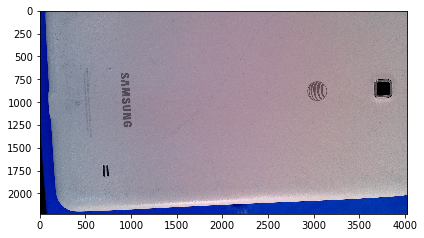

(144, 256, 256, 3)
144/144 [==============================] - 3s 22ms/step
1.0 2.1468868e-23
(2304, 4096, 3)


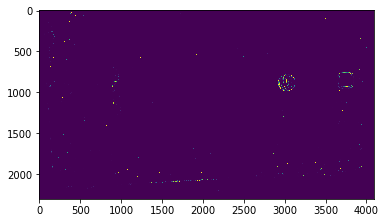

(48687, 3)


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


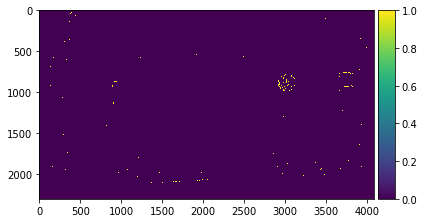

(1156, 2259, 3)
(45, 256, 256, 3)


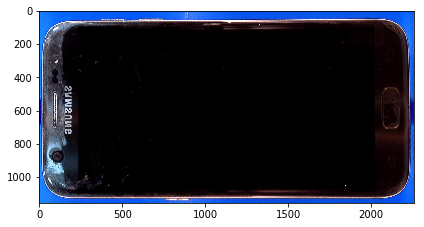

(45, 256, 256, 3)
45/45 [==============================] - 7s 157ms/step
1.0 9.021266e-23
(1280, 2304, 3)


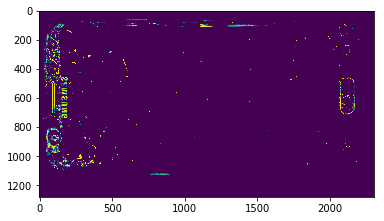

(122109, 3)


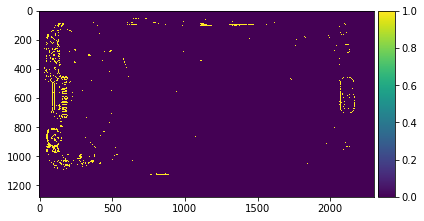

(2304, 3693, 3)
(150, 256, 256, 3)


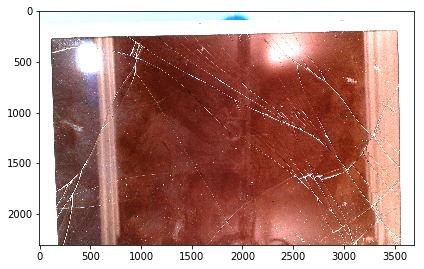

(150, 256, 256, 3)
150/150 [==============================] - 3s 22ms/step
1.0 2.316583e-27
(2560, 3840, 3)


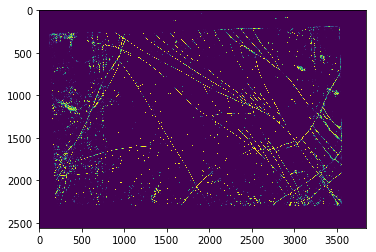

(878718, 3)


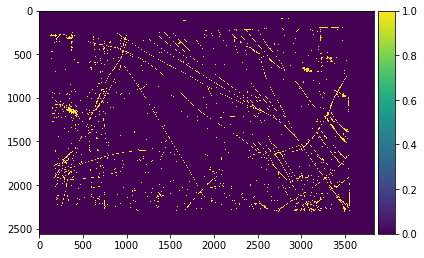

(2479, 3593, 3)


KeyboardInterrupt: 

In [9]:
from skimage import io as skio
import matplotlib.pyplot as io
from glob import glob
import cv2
testPath = glob('/home/ubuntu/DeepMobile/data/scratches/New_data/**.png')
#fully_trained_modelstestPath.sort()
h=256
w=256
no = 0
'''def FillImg(binImg):
    _, contours, hieqrarchy = cv2.findContours(np.uint8(binImg), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    newBinImg = np.zeros((binImg.shape[0],binImg.shape[1]),np.uint8())
    areas = [cv2.contourArea(c) for c in contours]
    if(len(areas)>0):
        max_index = np.argmax(areas)
        cnt = contours[max_index]
        cv2.drawContours(np.uint8(newBinImg), [cnt], 0, 255, -1)
        
    return newBinImg
'''
for i in range(len(testPath)):
    #tokens = testPath[i].split('/)
    #name = tokens[6].split('.')[0]
    img =cv2.imread(testPath[i],3)
    img = img.reshape(img.shape[0],img.shape[1],3)
    shape = img.shape
    img = np.asarray(img).astype('uint8')
   
    
    print(img.shape)
    #img = cv2.resize(img,dsize=(w,h),interpolation=cv2.INTER_AREA)
    #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #print(img.shape)
    #label = cv.resize(label,dsize=(324,256))

    #label = label.astype('uint8')
    #img = img.reshape(1,h,w,3)

    #print(img.shape)
    #imgss = img
    
    img = img/255.
    patches = prediction_patches(pad_input(img,patch_size=[h,w]),patch_size=[h,w])
    patches = np.asarray(patches)
    #label = label.reshape(512,648,1)
    print(patches.shape)
    #patches = patches.transpose([0,3,1,2])
    
    skio.imshow(img)
    skio.show()
    #img = (img-np.mean(img))/np.std(img)
    padded_input = pad_input(img)
    shape = padded_input.shape
    print(patches.shape)
    a,b,c,d,e,predicted_patches  = model1.predict(patches,batch_size=1,verbose=1)
    #predicted_patches = predicted_patches.transpose([0,2,3,1])
    predicted = reconstruct_patches(img_shape=shape,patches=predicted_patches)

    print(np.max(predicted),np.min(predicted))
    print(predicted.shape)
    io.imshow(predicted[:,:,0])
    io.show()
    thresh = np.argwhere(predicted>0.4)
    imgs = np.zeros(shape).astype('uint8')
    print(thresh.shape)
    for i in range(thresh.shape[0]):
        imgs[thresh[i][0],thresh[i][1],0]=1
    
    skio.imshow(imgs[:,:,0])
    skio.show()
    io.imsave('/home/ubuntu/DeepMobile/data/output_scratches/original/dilated__{}.png'.format(int(no)),img)
    io.imsave('/home/ubuntu/DeepMobile/data/output_scratches/predicted/dilated__{}.png'.format(int(no)),imgs[:,:,0])
    no+=1

In [ ]:
img  = img/255.
img = (img- np.mean(img))/ np.std(img)
img = img.reshape(1,320,480,3)

In [ ]:
out = model.predict(img)
print out.shape
out = out.transpose([0,3,1,2])
io.imshow(out[0][0])

In [ ]:
x = cv2.imread('/home/ubuntu/DeepMobile/data/output_scratches/original/dilated__1.png',3)
y = cv2.imread('/home/ubuntu/DeepMobile/data/output_scratches/predicted/dilated__1.png',0)
y = np.uint8(y)
print(y.shape)
(thresh, im_bw) = cv2.threshold(y, 125, 255, 0)
io.imshow(y)
io.show()
io.imshow(im_bw)
io.show()
print(np.max(im_bw))
obj = CreateGrid()
a,b,c,d,e = obj.WholeImgScratch(binImg=im_bw,rgbImg=x)


In [ ]:
io.imshow(a)
print(a.shape)

In [ ]:
from skimage import io as skio
import matplotlib.pyplot as io
from glob import glob
testPath = glob('/home/ubuntu/De')
for i in xrange(len(testPath)):
    tokens = testPath[i].split('/')
    name = tokens[6].split('.')[0]
    img = skio.imread(testPath[i])
    io.imshow(img)
    io.show()
    img  = img/255.
    img = (img-np.mean(img))/np.std(img)
    if img.shape==(320,480,3):
        print 'yes'
    else:
        img = img.transpose([1,0,2])
    img = img.reshape(1,320,480,3)
    x = np.random.normal(loc=0.0, scale=1.0, size=(256,256,3))
    predicted = model.predict(img)
    predicted = predicted.transpose([0,3,1,2])
    io.imshow(predicted[0][0])
    io.show()
    thresh = np.argwhere(predicted>0.000001)
    for i in xrange(thresh.shape[0]):
        predicted[thresh[i][0],thresh[i][1],thresh[i][2],thresh[i][3]]=255
    
    io.imshow(predicted[0][0])
    io.show()
    

In [ ]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [ ]:
get_model_memory_usage(4,model)

In [ ]:
tiramisu

In [ ]:
#model.save('/home/ubuntu/DeepMobile/models/unet/unetNoMaxPool2.h5')
model1.save_weights('/home/ubuntu/DeepMobile/production_code/fully_trained_models/HED-best-myown.h5')

In [ ]:
import cv2
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
    #img = np.asarray(img).astype('float32')
    img = cv2.resize(frame,dsize=(1024,1024),interpolation=cv2.INTER_AREA)

    img = np.asarray(img).astype('uint8')
   
    
    print(img.shape)
    #img = cv2.resize(img,dsize=(w,h),interpolation=cv2.INTER_AREA)
    #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #print(img.shape)
    #label = cv.resize(label,dsize=(324,256))

    #label = label.astype('uint8')
    #img = img.reshape(1,h,w,3)

    #print(img.shape)
    #imgss = img
    
    img = img/255.
    patches = prediction_patches(pad_input(img,patch_size=[h,w]),patch_size=[h,w])
    patches = np.asarray(patches)
    #label = label.reshape(512,648,1)
    print(patches.shape)
    #patches = patches.transpose([0,3,1,2])
    
    skio.imshow(img)
    skio.show()
    #img = (img-np.mean(img))/np.std(img)
    padded_input = pad_input(img)
    shape = padded_input.shape
    print(patches.shape)
    predicted_patches = model1.predict(patches,batch_size=1,verbose=1)
    #predicted_patches = predicted_patches.transpose([0,2,3,1])
    predicted = reconstruct_patches(img_shape=shape,patches=predicted_patches)

    print(np.max(predicted),np.min(predicted))
    print(predicted.shape)
    io.imshow(predicted[:,:,0])
    io.show()
    thresh = np.argwhere(predicted>0.5)
    imgs = np.zeros(shape).astype('uint8')
    print(thresh.shape)
    for i in range(thresh.shape[0]):
        imgs[thresh[i][0],thresh[i][1],0]=255
    
    skio.imshow(imgs[:,:,0])
    skio.show()
    cv2.imshow("preview", imgs)

cv2.destroyWindow("preview")
    

In [ ]:
modelDilated.save_weights('/home/ubuntu/DeepMobile/models/myown/HEDmy.h5')

In [ ]:
x = np.random.normal(loc=0.0, scale=1.0, size=(256,256,3))

In [ ]:
x.shape


In [ ]:
x = io.imread('/home/ubuntu/DeepMobile/data/scratches/label/label/1000.png')

In [ ]:
np.max(x)

In [7]:
model_json = model1.to_json()
with open("/home/ubuntu/DeepMobile/production_code/fully_trained_models/HED_Mue.json", "w") as json_file:
    json_file.write(model_json)
model1.save_weights('/home/ubuntu/DeepMobile/production_code/fully_trained_models/HED_Mue.h5')

In [ ]:
def predict_scratches(img=np.ones(1024,1026,3),model)
    h = 256
    w = 256
    img = img.reshape(img.shape[0],img.shape[1],3)
    shape = img.shape
    img = np.asarray(img).astype('uint8')
   
    
    print(img.shape)
    img = img/255.
    patches = prediction_patches(pad_input(img,patch_size=[h,w]),patch_size=[h,w])
    patches = np.asarray(patches)
    #label = label.reshape(512,648,1)
    print(patches.shape)
    #patches = patches.transpose([0,3,1,2])
    

    #img = (img-np.mean(img))/np.std(img)
    padded_input = pad_input(img)
    shape = padded_input.shape
    print(patches.shape)
    predicted_patches = model1.predict(patches,batch_size=1,verbose=1)
    #predicted_patches = predicted_patches.transpose([0,2,3,1])
    predicted = reconstruct_patches(img_shape=shape,patches=predicted_patches)

    print(np.max(predicted),np.min(predicted))
    print(predicted.shape)
    io.imshow(predicted[:,:,0])
    io.show()
    thresh = np.argwhere(predicted>0.5)
    imgs = np.zeros(shape).astype('uint8')
    print(thresh.shape)
    for i in range(thresh.shape[0]):
        imgs[thresh[i][0],thresh[i][1],0]=255
    
    skio.imshow(imgs[:,:,0])
    skio.show()
    return imgs